# Implementação de um modelo de Regressão Linear Regularizado com Ridge(L2).

In [ ]:
# 1. Importação das bibliotecas:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [3]:
# 2. Gerando dados de exemplo (com multicolinearidade):

np.random.seed(42)
n = 200
X1 = np.random.rand(n, 1) * 10
X2 = X1 + np.random.normal(0, 0.1, size=(n, 1)) # Altamente correlacionado com X1
X3 = np.random.rand(n, 1) * 10
y = 3 * X1 + 0.5 * X2 - 2 * X3 + np.random.rand(n, 1) * 2

X = np.hstack([X1, X2, X3])
df = pd.DataFrame(X, columns=["X1", "X2", "X3"])
df['y'] = y

,X1,X2,X3,y
0,3.745401,3.677399,4.242220,5.764145
1,9.507143,9.530368,9.063544,16.650405
2,7.319939,7.349247,1.111975,24.273811
3,5.986585,5.915150,4.926251,11.319988
4,1.560186,1.746764,0.113536,5.894420


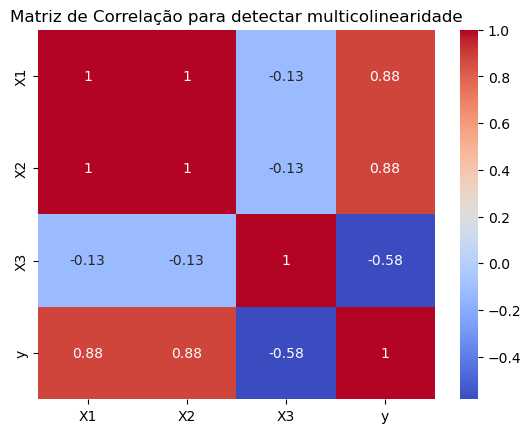

In [5]:
# 3. Exploração inicial:

display(df.head())

# Matriz de correlação para detectar multicolinearidade:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlação para detectar multicolinearidade")
plt.show()

In [8]:
# 4. Separando treino/teste:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Padronização(muito importante para Ridge!):
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# 5. Modelo Linear Simples:

modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)

y_pred_train_lin = modelo.predict(X_train_scaled)
y_pred_test_lin = modelo.predict(X_test_scaled)

print("=== Regressão Linear Simples ===")
print("Coeficientes:", modelo.coef_)
print("Intercepto:", modelo.intercept_)
print("R² Treino:", r2_score(y_train, y_pred_train_lin))
print("R² Teste:", r2_score(y_test, y_pred_test_lin))

=== Regressão Linear Simples ===
Coeficientes: [[ 6.68421717  3.58119684 -6.03867885]]
Intercepto: [7.73336168]
R² Treino: 0.9979438167879536
R² Teste: 0.9979825767058395


In [12]:
# 6. Regressão Ridge (com alpha=1.0): 

ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_scaled, y_train)

y_pred_train_ridge = ridge_reg.predict(X_train_scaled)
y_pred_test_ridge = ridge_reg.predict(X_test_scaled)

print("\n=== Regressão Ridge ===")
print("Coeficientes:", ridge_reg.coef_)
print("Intercepto:", ridge_reg.intercept_)
print("R² Treino:", r2_score(y_train, y_pred_train_ridge))
print("R² Teste:", r2_score(y_test, y_pred_test_ridge))


=== Regressão Ridge ===
Coeficientes: [[ 5.22490049  5.00641166 -6.00060122]]
Intercepto: [7.73336168]
R² Treino: 0.9979096531232682
R² Teste: 0.9978614148215242



Comparação de Coeficientes:


,Variável,Linear,Ridge
0,X1,6.684217,5.224900
1,X2,3.581197,5.006412
2,X3,-6.038679,-6.000601


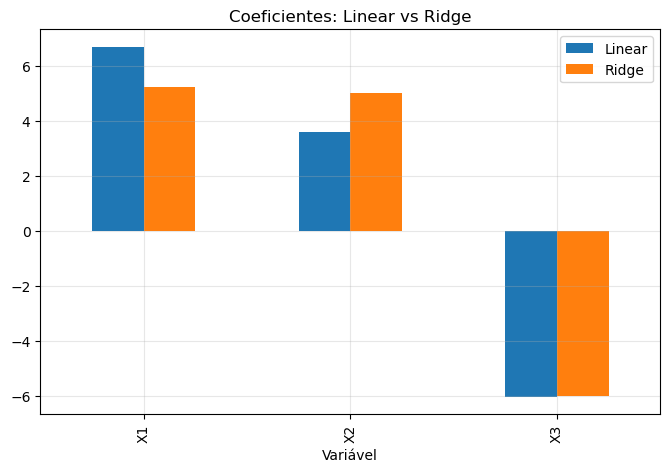

In [14]:
# 7. Comparando coeficientes:

coef_df = pd.DataFrame({
    "Variável": ["X1", "X2", "X3"],
    "Linear": modelo.coef_.flatten(),
    "Ridge": ridge_reg.coef_.flatten()
})

print("\nComparação de Coeficientes:")
display(coef_df)

coef_df.set_index("Variável").plot(kind="bar", figsize=(8,5))
plt.title("Coeficientes: Linear vs Ridge")
plt.grid(alpha=0.3)
plt.show()


Validação Cruzada Ridge (R² médio):
Alpha=0.01: R² = 0.9976
Alpha=0.1: R² = 0.9976
Alpha=1: R² = 0.9976
Alpha=10: R² = 0.9947
Alpha=100: R² = 0.8756


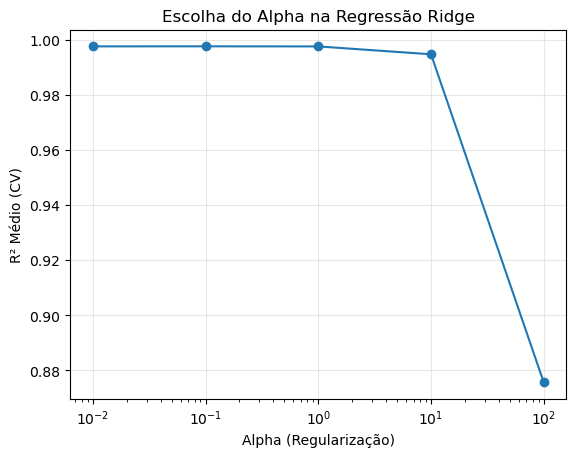

In [15]:
# 8. Validação Cruzada (para diferentes alphas):

alphas = [0.01, 0.1, 1, 10, 100]
ridge_cv_results = {}

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='r2')
    ridge_cv_results[alpha] = scores.mean()

print("\nValidação Cruzada Ridge (R² médio):")
for alpha, score in ridge_cv_results.items():
    print(f"Alpha={alpha}: R² = {score:.4f}")

plt.plot(list(ridge_cv_results.keys()), list(ridge_cv_results.values()), marker="o")
plt.xscale("log")
plt.xlabel("Alpha (Regularização)")
plt.ylabel("R² Médio (CV)")
plt.title("Escolha do Alpha na Regressão Ridge")
plt.grid(alpha=0.3)
plt.show()

In [18]:
# 9. Escolher o melhor alpha e treinar o modelo final:

best_alpha = max(ridge_cv_results, key=ridge_cv_results.get)
print(f"\nMelhor alpha escolhido: {best_alpha}")

ridge_final = Ridge(alpha=best_alpha)
ridge_final.fit(X_train_scaled,  y_train)

y_pred_train_final = ridge_final.predict(X_train_scaled)
y_pred_test_final = ridge_final.predict(X_test_scaled)


Melhor alpha escolhido: 0.1


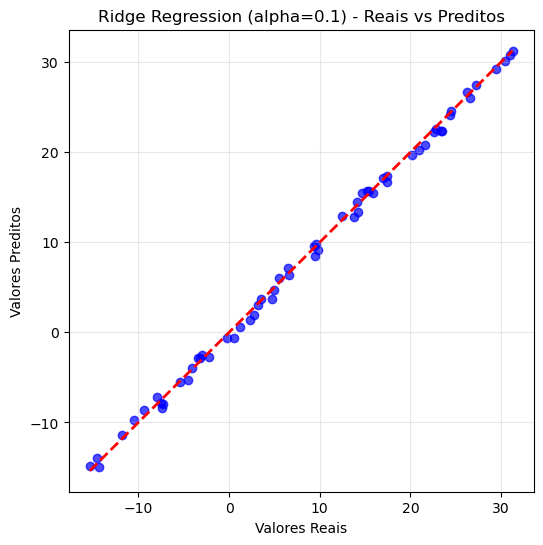

In [19]:
# 10. Plotar previsões reais vs preditas:

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test_final, alpha=0.7, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
plt.title(f"Ridge Regression (alpha={best_alpha}) - Reais vs Preditos")
plt.grid(alpha=0.3)
plt.show()

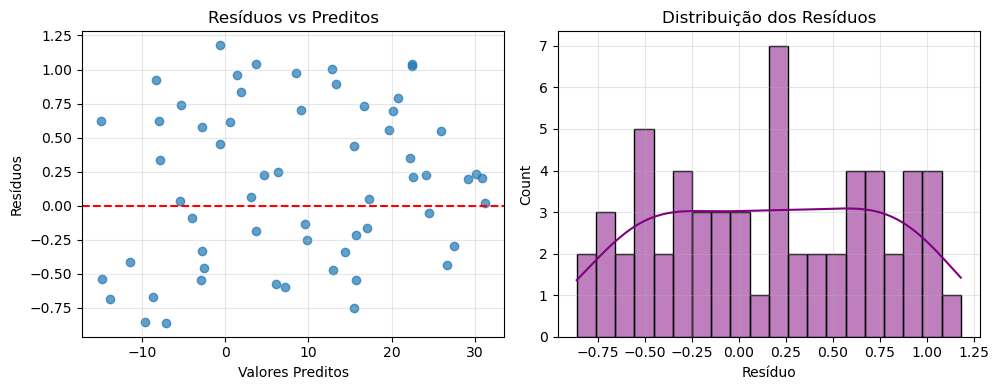

In [20]:
# 11. Análise de Resíduos:

residuos = y_test.flatten() - y_pred_test_final.flatten()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(y_pred_test_final, residuos, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos")
plt.title("Resíduos vs Preditos")
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
sns.histplot(residuos, kde=True, bins=20, color="purple")
plt.title("Distribuição dos Resíduos")
plt.xlabel("Resíduo")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [22]:
# 12. Métricas de avaliação:

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_final))
r2 = r2_score(y_test, y_pred_test_final)
mape = mean_absolute_percentage_error(y_test, y_pred_test_final) * 100

print("\n=== Desempenho Final ===")
print(f"MAPE = {mape:.4f}%")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")


=== Desempenho Final ===
MAPE = 14.2212%
RMSE = 0.5977
R²   = 0.9979
